# Human's emotion recognition using thermal images
## *TEACHER: NGUYEN VIET HUNG*
## *MEMBER*
- Vuong Le Minh Nguyen
- Luong Cong Tam

#### Import Library & Settings

In [1]:
import pandas as pd
import sklearn
import scipy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import random
import IPython.display as display
from configparser import ConfigParser
from time import sleep

np.set_printoptions(threshold=np.inf) # Setting for full numpy matrices printing

In [2]:
# Load db config:
dbconfig = ConfigParser()
dbconfig.read('database.ini')

# Assign dbDir with local config:
dbDir = dbconfig['LOCAL']['location'] #Database directory
eDir = {
    "angry":"anger",
    "fear":"fear",
    "happy":"happy",
    "sad":"sadness",
    "neutral":"neutral"
} #Name of directory of each Emotion

#### Function definition

In [3]:
def frameShow(frame):
    w, h = frame.shape
    ret = cv2.imencode('.jpeg',frame)[1]
    i = display.Image(data=ret, width = w, height = h)
    display.display(i)
    sleep(0.05)
#     display.clear_output(True)

In [4]:
def getSVXFiles(fd):
    return glob.glob(fd + '/*.svx')

In [5]:
def readSVX(file, frame_limit = 6990):
    # Default frame_limit is based on the requirement of at least 1GB of free RAM (6990*153600B ~~ 1GB)
    # Open file to read:
    f = open(file,'rb') 
    
    # Skip 128 bytes from the file's beginning:
    f.seek(128) 
    
    # Calculate grayscale converter:
    [CA,CB] = np.divide(np.frombuffer(f.read(8), dtype=np.dtype('<i4'), count=2), 2**16)
    #Array from buffer
    #Data type: int32 (4 bytes/each - 'i4') 
    #Byte-order:  Litte-endian ('<')
    
    # Skip to the beginning of first frame to start reading:
    f.seek(1104) 
    
    list_img2d = []

    for i in range (0,frame_limit):
        buffer = f.read(153600)
        
        # Check EOF:
        if len(buffer) < 153600:
            break
        
        img = np.frombuffer(buffer,dtype=np.dtype('>i2'))
        #Array from buffer
        #Data type: int16 (2 bytes/each - 'i2') 
        #Byte-order:  Big-endian ('>')
        
        # Convert read img to grayscale (temperature) using converter, then reshape from 1D to 2D:
        img2d = (img * CB + CA).reshape(240,320)
        
        # Add read frame to the result array:
        list_img2d.append(img2d) 
        
        # Move to the beginning of next frame to continue reading:
        f.seek(2592,1) 
    
    f.close()
    return np.array(list_img2d)

In [6]:
def getTROIs(frame):
    Tmax = np.amax(frame)
    Tmin = np.amin(frame)
    
    # Map current frame to 8-bit grayscale:
    lbound = np.floor(Tmin)
    rbound = np.ceil(Tmax)
#     grayImg = ((frame-lbound)*256/(rbound-lbound)).astype(int)
    grayImg = (frame*256/rbound).astype(int)
    frameShow(grayImg)
    
    # Get the pixel with the highest intensity in grayscale:
    T_icmgr = np.argmax(np.bincount(grayImg.reshape(240*320)))
    
    # Calculate delta t:
    deltaT = (Tmax - Tmin)/T_icmgr
#     print(deltaT)
    # Get TROIs:
    TROIs = frame
    for i in range(TROIs.shape[0]):
        for j in range(TROIs.shape[1]):
            if frame[i][j] > Tmax - deltaT * TROIs[i][j] or frame[i][j] < Tmin + deltaT * TROIs[i][j]:
                TROIs[i][j] = 0
    
    return TROIs
    

In [7]:
def getGrayImage(frame, bit_depth = 8):
    Tmax = np.amax(frame)
    Tmin = np.amin(frame)
    
    # Map current frame to 8-bit grayscale:
    lbound = np.floor(Tmin)
    rbound = np.ceil(Tmax)
    scale = 2**bit_depth
    grayImg = ((frame-lbound)*scale/(rbound-lbound)).astype(int)
    
    return grayImg

In [8]:
def getFace(frame):
    # TODO - getFace function
    xF, yF = frame.shape
    print(xF, yF)
    tE, rE, bE, lE = xF, 0, 0, yF
    print(tE, rE, bE, lE)
    for x in range(xF):
        for y in range(yF):
            if (frame[x][y] < 29.0):
                frame[x][y] = 0
            else:
                tE = min(tE, x)
                rE = max(rE, y)
                lE = min(lE, y)
    
    # Find bottomEdge
    mP = (rE + lE) // 2
    print(mP)
    for i in range(130, xF-1):
        if abs(frame[i][mP] - frame[i+1][mP]) > 00.60:
            print(frame[i][mP], frame[i+1][mP])
            bE = i
            break
            
    print(tE, rE, bE, lE)
    
    print(frame[lE:rE:1, tE:bE:1].shape)
    plt.imshow(frame[tE:bE, lE:rE])
#     plt.show()

In [9]:
def frameCaRs(frame, width, height):
    # TODO - frame Crop and Resize function
    return 0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000FB167B8>],
      dtype=object)

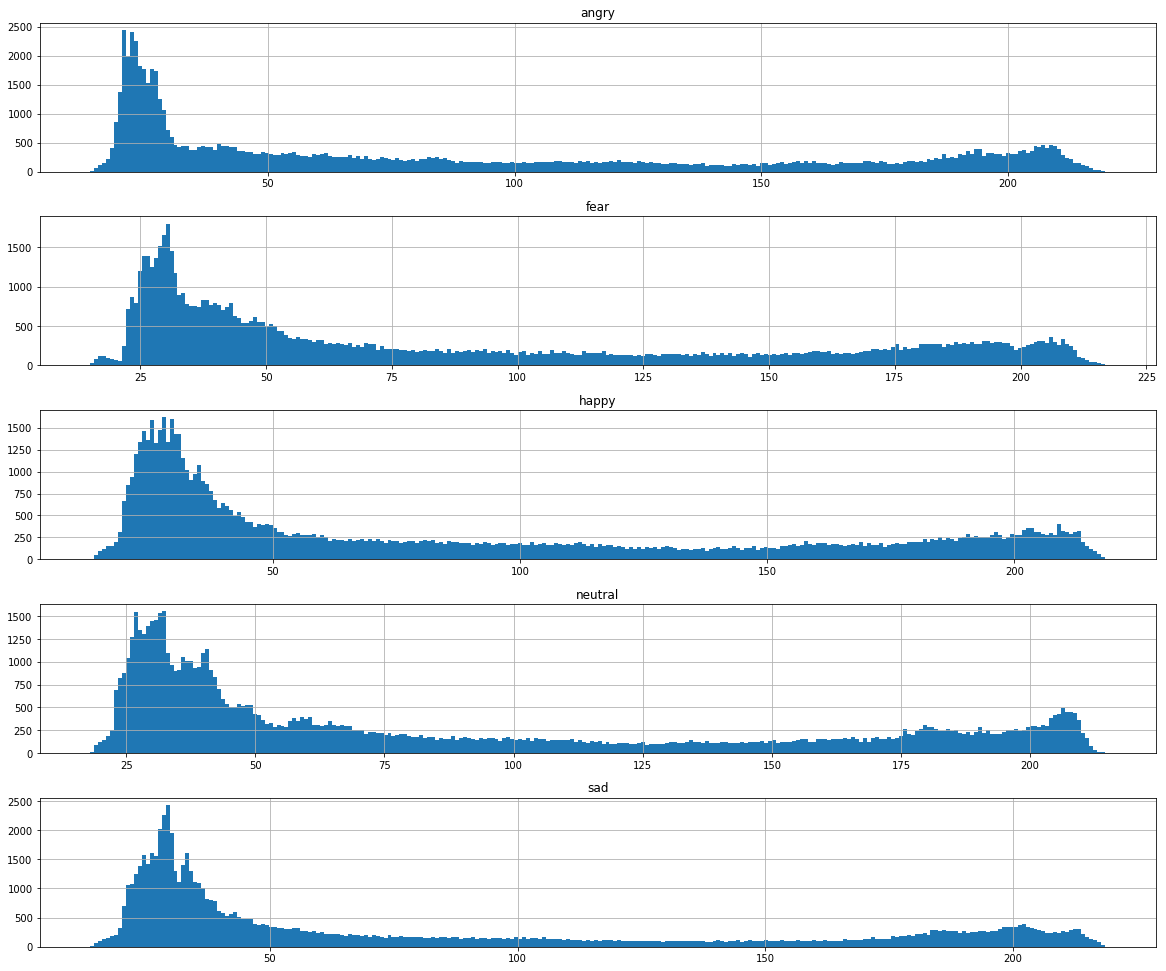

In [17]:
# Demo reading imgs from SVX Files:
train = dict()
for e in eDir:
    avgGrayImg = np.zeros(240*320)
    cnt = 0
    for file in getSVXFiles(dbDir+eDir[e]):
        data = readSVX(file, 1)
        grayImg = getGrayImage(data[0])
#         frameShow(grayImg)
        avgGrayImg = avgGrayImg + grayImg.reshape(240*320)
        cnt += 1
        data = None
    train[e] = avgGrayImg/cnt
pd.DataFrame(train).hist(bins = 256, figsize = (20, 17), layout = (5,1))